**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [1]:
! pip install lightning torchmetrics torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.2 MB/s eta 0:00:00


3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [2]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

# Génération d'images de chiffres par auto-encodeur variationnel



### Exercice 1

Créez les *datasets* puis les *dataloaders* pour les jeux d'entraînement et de validation du jeu de données MNIST, implémentée dans la classe [torchvision.datasets.MNIST()](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), en utilisant les informations suivantes :

* Concernant les *datasets*, n'oubliez pas de transformer les entrées brutes, qui sont des images PIL d'entiers entre $0$ et $255$, en tenseurs de nombres flottants à $32$ bits compris enter $0.0$ et $1.0$.

* Concernant les *dataloaders*, on utilisera des lots de taille $64$. Les observations sont mélangées sur le jeu d'entraînement, mais pas sur le jeu de validation.

Vous pouvez vous inspirer du code du TP 2.2.

In [3]:
# Création des datasets
import torch
from torchvision.datasets import EMNIST
from torchvision.transforms import v2


dataset_train = EMNIST(
    root='data',
    split='letters',
    download=True,
    train=True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    target_transform=lambda x: x - 1
)

dataset_val = EMNIST(
    root='data',
    split='letters',
    download=True,
    train=False,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    target_transform=lambda x: x - 1
)

100%|██████████| 562M/562M [00:22<00:00, 25.2MB/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [4]:
# Création des dataloaders
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=64)

### Exercice 2

Calculez la taille d'une image. On admettra que toutes les images ont la même taille.

In [5]:
dataloader_train.dataset[0][0].shape #Image 28*28 avec un canal (images en nuance de gris)

torch.Size([1, 28, 28])

On visualise quelques observations du jeu d'entraînement :

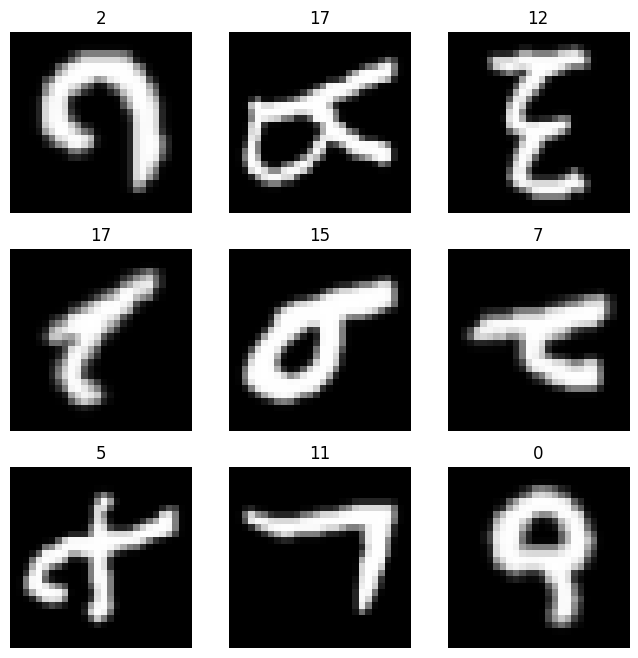

In [6]:
import matplotlib.pyplot as plt


figure = plt.figure(figsize=(8, 8))

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Architecture et entraînement du modèle

Un auto-encodeur variationnel est une variante générative de l'auto-encodeur.

### Architecture

L'image ci-dessous résume l'architecture que vous allez implémenter :

[<img src="https://raw.githubusercontent.com/johannfaouzi/apprentissage-profond-ensai/main/figures/vae_computation_graph.png" width="650"/>](https://raw.githubusercontent.com/johannfaouzi/apprentissage-profond-ensai/main/figures/vae_computation_graph.png)

Un auto-encodeur est composé de deux éléments : l'encodeur (dénoté par $q$ sur l'image) puis le décodeur (dénoté par $p$ sur l'image).

L'entrée de l'encodeur, dénotée par $x$, est une image de chiffre.
La sortie de l'encodeur est composée de deux vecteurs : la moyenne $\mu$ et le logarithme de la variance $\log(\sigma^2)$ d'une distribution gaussienne multivariée $\mathcal{N}(\mu, \sigma^2)$.
On suppose que la matrice de covariance est diagonale, c'est pourquoi elle est caractérisée par un simple vecteur (correspondant à la diagonale de cette matrice).

L'entrée du décodeur est une variable aléatoire générée selon la loi $\mathcal{N}(\mu, \sigma^2)$.
Pour obtenir une telle variable, on génère d'abord un vecteur aléatoire ${z}$ selon la loi $\mathcal{N}(0, I)$, puis on applique la transformation affine $\mu + \sigma \odot z$ qui suit la loi $\mathcal{N}(\mu, \sigma^2)$.

La dimension de l'espace latent, dénotée par `latent_dim`, sera un hyperparamètre de notre classe.
On utilisera la valeur par défaut, c'est-à-dire `latent_dim = 8`.

Concernant l'encodeur, vous implémenterez l'architecture séquentielle suivante :

* Couche d'aplatissement
* Couche linéaire avec $512$ variables en sortie
* Fonction d'activation ReLU
* Couche linéaire avec $256$ variables en sortie
* Fonction d'activation ReLU
* Couche linéaire avec $2 \times$ `latent_dim` variables en sortie

La sortie de l'encodeur est un tenseur à une dimension, c'est-à-dire un vecteur, de taille $2 \times$ `latent_dim` car il contient à la fois le tenseur de taille `latent_dim` pour la moyenne $\mu$ et le tenseur de taille `latent_dim` pour le logarithme de la variance $\log(\sigma^2)$.

Concernant le décodeur, vous implémenterez l'architecture séquentielle suivante :

* Couche linéaire avec $256$ variables en sortie
* Fonction d'activation ReLU
* Couche linéaire avec $512$ variables en sortie
* Fonction d'activation ReLU
* Couche linéaire avec $784$ variables en sortie
* Fonction d'activation Sigmoïde
* Couche de désaplatissement

Le rôle de la dernière couche est de transformer le vecteur en image, c'est-à-dire un tenseur à trois dimensions.

Voici les liens vers la documentation des outils pertinents pour construire ces deux architectures :
[torch.nn.Flatten()](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html),
[torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html),
[torch.nn.ReLU()](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html),
[torch.nn.Sigmoid()](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) et
[torch.nn.Unflatten()](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html).

Pour générer des variables aléatoires indépendantes selon la loi gaussienne centrée réduite, vous pouvez utiliser la fonction [torch.randn()](https://pytorch.org/docs/main/generated/torch.randn.html).

### Fonction de perte

La fonction de perte $J$, composée de deux termes différents, est définie par l'équation suivante :
$$
    J(\tilde{x}, x) = \text{BCE}(\tilde{x}, x) - \lambda \times KL
$$
où :
* $x$ est l'image originale (en entrée de l'encodeur) et $\tilde{x}$ est l'image reconstruite (en sortie du décodeur),
$\text{BCE}(\tilde{x}, x)$ est l'entropie croisée entre $\tilde{x}$ et $x$ : elle correspond à l'**erreur de reconstruction**.
* $KL$ est la [divergence de Kullback-Leibler](https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler) entre la distribution utilisée $\mathcal{N}(\mu, \sigma^2)$ et la distribution cible $\mathcal{N}(0, I)$ : elle incite l'espace latent à suivre une distribution gaussienne isotropique. Sa formule est la suivante :
$$
    KL = \frac{1}{2} \sum_{i=1}^p \left( 1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2 \right)
$$
où $\mu = (\mu_1, \ldots, \mu_p)$, $\sigma = (\sigma_1, \ldots, \sigma_p)$ et $p$ est la dimension de l'espace latent.
* $\lambda$ est le terme de pondération de la divergence de Kullback-Leibler par rapport à l'entropie croisée binaire.

Voici le lien vers la documentation de [torch.nn.BCELoss()](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).
Pour la divergence de Kullback-Leibler, vous pouvez utiliser les fonctions
[torch.sum()](https://pytorch.org/docs/stable/generated/torch.sum.html),
[torch.exp()](https://pytorch.org/docs/stable/generated/torch.exp.html) et
[torch.pow()](https://pytorch.org/docs/stable/generated/torch.pow.html).

### Évaluation

Pour comparer les images reconstruites avec les images originales, nous utiliserons la [*structural similarity index measure*](https://en.wikipedia.org/wiki/Structural_similarity_index_measure).
Plus d'explications sur cette métrique seront fournies dans un prochain notebook.
Tout ce dont vous avez besoin de savoir pour le moment est que ses valeurs sont comprises entre $0$ (le pire) et $1$ (le meilleur).

### Exercice 3

Complétez les méthodes `__init__()`,  `encode()`, `reparametrize()`, `decode()`, `forward()` et `loss_function()` de la classe `VAE()` en utilisant les informations fournies ci-dessus.

In [17]:
import lightning as L
from torchmetrics.image import StructuralSimilarityIndexMeasure


class VAE(L.LightningModule):
    """Classe pour l'auto-encodeur variationnel."""
    def __init__(self, latent_dim=8):
        super().__init__()

        if not (isinstance(latent_dim, int) and latent_dim > 0):
            raise ValueError(
                "La dimension de l'espace latent doit être un entier strictement positif."
            )
        self.latent_dim = latent_dim

        ### BEGIN TODO ###
        # Initialisation de l'encodeur
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2*latent_dim)
        )

        # Initialisation du décodeur
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,784),
            torch.nn.Sigmoid(),
            torch.nn.Unflatten(dim=1, unflattened_size=(1,28,28))
        )

        # Initialisation de l'entropie croisée
        self.bce_loss =  torch.nn.BCELoss()

        # Pondération de la KL divergence comparée à l'entropie croisée binaire
        self.lambda_kld = 1e-4

        # Initialisation des métriques
        self.metric_train = StructuralSimilarityIndexMeasure()
        self.metric_val = StructuralSimilarityIndexMeasure()
        #### END TODO ####

    def encode(self, x):
        """Effectue une passe avant de l'encodeur.

        Parameters
        ----------
        x : Tensor, shape = [batch_size, 1, 28, 28]
            Lots de vraies images.

        Returns
        -------
        mu : Tensor, shape = [batch_size, latent_dim]
            Moyennes des distributions gaussiennes.

        log_var : Tensor, shape = [batch_size, latent_dim]
            Logarithmes des variance des distributions gaussiennes.
        """
        ### BEGIN TODO ###
        latent_dim = self.latent_dim
        mu = self.encoder(x)[:,0:latent_dim]
        log_sigma = self.encoder(x)[:,latent_dim:2*latent_dim]
        #### END TODO ####

        return mu, log_sigma

    def reparametrize(self, mu, log_var):
        """Reparamétrisation du modèle.

        On génère une variable aléatoire `z` selon la loi N(0, 1) et,
        grâce à la moyenne et au logarithme de la variance fournies en
        arguments, on génère une variable aléatoire selon la loi N(mu, var)
        par la transformation affine mu + z * std.

        Parameters
        ----------
        mu : Tensor, shape = [batch_size, latent_dim]
            Moyenne de la distribution gaussienne.

        log_var : Tensor, shape = [batch_size, latent_dim]
            Logarithme de la variance de la distribution gaussienne.
        """
        ### BEGIN TODO ###
        z = torch.randn(mu.shape) * torch.exp(log_var) + mu
        #### END TODO ####
        return z

    def decode(self, z):
        """Effectue une passe avant du décodeur.

        Parameters
        ----------
        z : Tensor, shape = [batch_size, latent_dim]
            Variables aléatoires selon la loi N(mu, var)

        Returns
        -------
        x_reconstructed : Tensor, shape = [batch_size, 1, 28, 28]
            Images générées.
        """
        ### BEGIN TODO ###
        x_reconstructed = self.decoder(z)
        #### END TODO ####
        return x_reconstructed

    def forward(self, x):
        """Effectue une passe avant.

        Parameters
        ----------
        x : Tensor, shape = [batch_size, 1, 28, 28]
            Lots de vraies images.

        Returns
        -------
        x_renconstructed : Tensor, shape = [batch_size, 1, 28, 28]
            Lots d'images générées.

        mu : Tensor, shape = [batch_size, latent_dim]
            Moyenne de la distribution gaussienne.

        log_var : Tensor, shape = [batch_size, latent_dim]
            Logarithme de la variance de la distribution gaussienne.
        """
        ### BEGIN TODO ###
        mu, log_var = self.encode(x)
        z = self.reparametrize(mu, log_var)
        x_renconstructed = self.decode(z)
        #### END TODO ####
        return x_renconstructed, mu, log_var

    def loss_function(self, x_reconstructed, x, mu, log_var):
        """Calcule la fonction de coût d'un VAE.

        Parameters
        ----------
        x : Tensor, shape = [batch_size, 1, 28, 28]
            Lots d'images.

        x_reconstructed : Tensor, shape = [batch_size, 1, 28, 28]
            Lots d'images reconstruites.

        mu : Tensor, shape = [batch_size, latent_dim]
            Moyenne de la distribution gaussienne.

        log_var : Tensor, shape = [batch_size, latent_dim]
            Logarithme de la variance de la distribution gaussienne.

        Returns
        -------
        loss : Tensor, shape = []
            Évaluation de la fonction de coût.
        """
        ### BEGIN TODO ###
        bce = torch.nn.functional.binary_cross_entropy(x_reconstructed, x, reduction="sum")
        kld = 0.5 * torch.sum(1 + log_var - torch.pow(mu,2) - log_var.exp())
        #### END TODO ####
        return bce - self.lambda_kld * kld

    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.

        dataset : {"training", "validation"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = []
            La fonction de coût pour ce lot d'observations.
        """
        x, _ = batch
        x_reconstructed, mu, log_var = self(x)
        loss = self.loss_function(x_reconstructed, x, mu, log_var)

        if dataset == "training":
            name = "train"
            metric = self.metric_train
            bar_step = True
        else:
            name = "val"
            metric = self.metric_val
            bar_step = False

        ssim = metric(x_reconstructed, x)
        self.log(f"loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"ssim_{name}", ssim, prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss

    def training_step(self, batch):
        return self.step(batch, "training")

    def validation_step(self, batch):
        return self.step(batch, "validation")

    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")

    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            -----------------------------------------------
            |     Jeu      | Fonction de perte |   SSIM   |
            | ------------ | ----------------- | -------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['ssim_train'].item():^10.6f}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['ssim_val'].item():^10.6f}|
            -----------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.split('\n')])
        print(string)

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

### Exercice 4

Affichez un résumé de l'architecture. Combien de paramètres entraînables a-t-elle ?

In [18]:
from torchinfo import summary

summary(VAE(), input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [64, 1, 28, 28]           --
├─Sequential: 1-1                        [64, 16]                  --
│    └─Flatten: 2-1                      [64, 784]                 --
│    └─Linear: 2-2                       [64, 512]                 401,920
│    └─ReLU: 2-3                         [64, 512]                 --
│    └─Linear: 2-4                       [64, 256]                 131,328
│    └─ReLU: 2-5                         [64, 256]                 --
│    └─Linear: 2-6                       [64, 16]                  4,112
├─Sequential: 1-2                        [64, 16]                  (recursive)
│    └─Flatten: 2-7                      [64, 784]                 --
│    └─Linear: 2-8                       [64, 512]                 (recursive)
│    └─ReLU: 2-9                         [64, 512]                 --
│    └─Linear: 2-10                      [64, 256]    

**Réponse** : 1 073 440 paramètres entrainables

### Exercice 5

Entraînez votre modèle pendant $20$ époques.

In [21]:
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger


model_vae = VAE()

trainer = L.Trainer(
    max_epochs=5, #5 époques pour gain de temps (impossible d'aller sur le GPU)
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    callbacks=[TQDMProgressBar(refresh_rate=100)]  # mettre à jour la barre de progression tous les 100 lots
)

trainer.fit(
    model=model_vae,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |          | 0/? [00:00<?, ?it/s]

Version 2



Validation: |          | 0/? [00:00<?, ?it/s]


Époque 1 / 5
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |    11077.14746    | 0.615108 |
|  Validation  |    9608.48145     | 0.714112 |
-----------------------------------------------



Validation: |          | 0/? [00:00<?, ?it/s]


Époque 2 / 5
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |    9321.10840     | 0.734938 |
|  Validation  |    9129.12793     | 0.748865 |
-----------------------------------------------



Validation: |          | 0/? [00:00<?, ?it/s]


Époque 3 / 5
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |    8995.32812     | 0.757691 |
|  Validation  |    8951.39551     | 0.760652 |
-----------------------------------------------



Validation: |          | 0/? [00:00<?, ?it/s]


Époque 4 / 5
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |    8816.59668     | 0.770011 |
|  Validation  |    8812.32520     | 0.770981 |
-----------------------------------------------



Validation: |          | 0/? [00:00<?, ?it/s]


Époque 5 / 5
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |    8696.85547     | 0.778354 |
|  Validation  |    8715.31250     | 0.778224 |
-----------------------------------------------



Maintenant que l'auto-encodeur variationnel est entraîné, on souhaite visualiser des images générées par ce modèle.
La première étape est de générer des images avec le modèle.

On rappelle le processus de génération d'un auto-encodeur variationnel :

* On génère une variable aléatoire $z$ selon la loi normale centrée réduite : $z \sim \mathcal{N}(0, 1)$
* On fournit $z$ en entrée du décodeur qui renvoie l'image correspondante.

### Exercice 6

La fonction `generate_digit_images()` permet de générer et de renvoyer $64$ images générées par un auto-encodeur variationnel entraîné.
Complétez le code manquant dans cette fonction.

In [29]:
def generate_digit_images(model):
    """Génère des images de chiffres.

    Parameters
    ----------
    model : VAE
        Auto-encodeur variationnel entraîné.

    Returns
    -------
    x_gen : Tensor, shape = [64, 1, 28, 28]
        64 images de chiffres générées par le modèle.
    """
    ### BEGIN TODO ###
    z = torch.randn(64, model.latent_dim)
    x_gen = model.decode(z)
    #### END TODO ####
    return x_gen

### Exercice 7

Utilisez la fonction `plot_generated_images()` définie ci-dessous pour afficher des images générées par votre auto-encodeur variationnel.

In [44]:
def plot_generated_images(model):
    x_gen = torch.squeeze(generate_digit_images(model).detach().cpu())

    plt.figure(figsize=(6, 6))

    plt.imshow(torch.cat([
        torch.cat([x_gen[i] for i in range(8 * j, 8 * (j + 1))])
        for j in range(8)
    ], dim=1), cmap='gray')

    plt.xticks([]); plt.yticks([]);
    plt.title("Generated images");

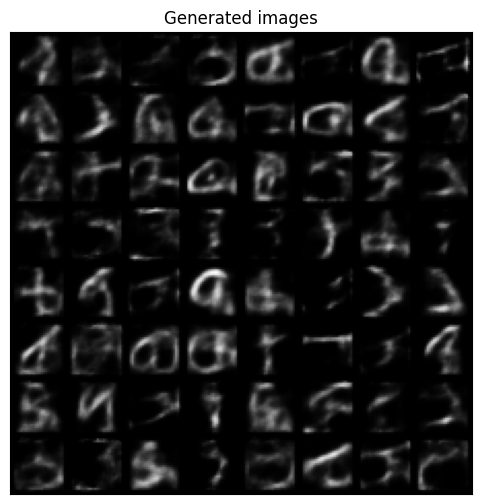

In [45]:
plot_generated_images(model_vae)